In [1]:
from data_processing import *

data, OUT_DIM = load_create_ellipticpp()
batch_size = 10
loader = split_into_batches(data, num_batches=batch_size, num_hops=2, num_neighbours=100)
num_features = next(iter(loader)).x.shape[-1]
data

Data(x=[51108, 55], y=[51108], edge_index=[2, 84088], train_mask=[51108], val_mask=[51108], test_mask=[51108])

In [2]:
next(iter(loader))

Data(x=[14, 55], y=[14], edge_index=[2, 26], train_mask=[14], val_mask=[14], test_mask=[14], n_id=[14], e_id=[26], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[10], batch_size=10)

In [3]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SAGE(torch.nn.Module):
    def __init__(self, in_dim, out_dim, **layer_paras):
        super().__init__()

        self.num_layers = layer_paras.pop("num_layers",2)
        self.hidden_dim = layer_paras.pop("hidden_channels")
        self.cached = layer_paras.pop("cached", True)

        self.dropout = layer_paras.pop("dropout", 0.0)

        self.conv_layers = []

        self.conv_layers += [
            SAGEConv(in_dim, self.hidden_dim) # input layer; cached=True => for transductive learning
        ]
        for _ in range(self.num_layers-2):
            self.conv_layers += [
                SAGEConv(self.hidden_dim, self.hidden_dim)
            ]
        self.conv_layers += [
            SAGEConv(self.hidden_dim, out_dim) # output layer; cached=True => for transductive learning
        ]

        self.conv_layers = torch.nn.ParameterList(self.conv_layers)

    def forward(self, x, edge_index):
        for conv in self.conv_layers[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv_layers[-1](x, edge_index)

        return F.log_softmax(x, dim=1)

In [4]:
paras = {
    'lr':0.01,
    'num_layers':4,
    'hidden_channels':128,
    'dropout':0.0,
    'batchnorm': False,
    'l2':5e-7,
    'cached': True,
}


In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SAGE(in_dim=num_features, out_dim=OUT_DIM, **paras).to(DEVICE)
model

SAGE(
  (conv_layers): ParameterList(
      (0): Object of type: SAGEConv
      (1): Object of type: SAGEConv
      (2): Object of type: SAGEConv
      (3): Object of type: SAGEConv
    (0): SAGEConv(55, 128, aggr=mean)
    (1): SAGEConv(128, 128, aggr=mean)
    (2): SAGEConv(128, 128, aggr=mean)
    (3): SAGEConv(128, 2, aggr=mean)
  )
)

In [6]:
data.x.shape[0]//batch_size

5110

In [7]:
data.y

tensor([1, 2, 2,  ..., 1, 2, 2], device='cuda:0')

In [8]:
from tqdm import tqdm

def train(batches, model, optimizer, epoch_num=1):
    loss_all = []
    loss_valid_all = []

    model.train()
    iterator = tqdm(range(epoch_num), desc="")
    for epoch in iterator:
        running_loss = 0
        running_valid_loss = 0
        for idx, batch in enumerate(batches):
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)

            loss = F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask])
            running_loss += loss.item()    

            loss.backward()
            optimizer.step()

            loss_valid = F.nll_loss(out[batch.val_mask], batch.y[batch.val_mask])
            running_valid_loss += loss_valid.item()    

            iterator.set_description(f"Epoch: {epoch}/{epoch_num}; Batch: {idx}/{data.x.shape[0]//batch_size}; Loss: {running_loss/(idx+1):0.4f}")

        # @TODO: add validation round to monitor performance
        loss_all += [running_loss/(data.x.shape[0]//batch_size)]
        loss_valid_all += [running_valid_loss/(data.x.shape[0]//batch_size)]

        iterator.set_description(f"Epoch: {epoch}/{epoch_num}; Batch: {idx}; Loss={loss_all[-1]:.4f}; Loss-Validation={loss_valid_all[-1]:.4f}")

    return loss_all, loss_valid_all

optimizer = torch.optim.Adam(model.parameters(), lr=paras["lr"], weight_decay=paras["l2"])

loss_all, loss_valid_all = train(loader, model, optimizer, epoch_num=100)


Epoch: 0/100; Batch: 866/5110; Loss: nan:   0%|          | 0/100 [00:08<?, ?it/s]       


KeyboardInterrupt: 

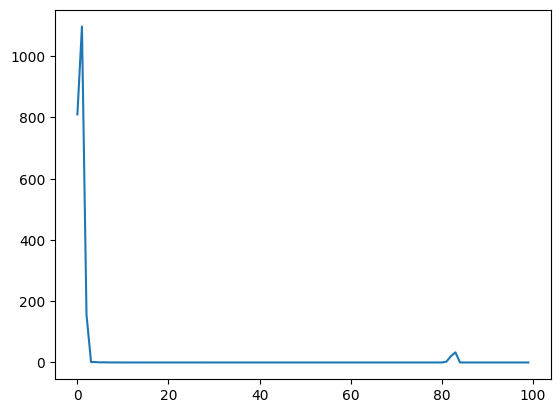

In [68]:
import matplotlib.pyplot as plt

plt.plot(loss_all)
plt.plot(loss_valid_all)

In [72]:
from torch_geometric.explain.metric import groundtruth_metrics

avg_scores = []
model.eval()
for batch in tqdm(loader, total=dataset.x.shape[0]//batch_size):
    pred = model(batch.x, batch.edge_index).argmax(dim=1)
    scores = groundtruth_metrics(
        pred_mask=pred[batch.test_mask],
        target_mask=batch.y[batch.test_mask],
        threshold=0.5,
        metrics=["accuracy", "precision", "recall", "f1_score"]
    )
    avg_scores += [scores]

52it [00:00, 147.69it/s]                        


In [73]:
import numpy as np

np.asarray(avg_scores).mean(axis=0)

array([0.99704236, 0.99704236, 1.        , 0.99851812])

In [74]:
# from torch_geometric.explain.metric import groundtruth_metrics

# model.eval()
# pred = model(train_data).argmax(dim=1)

# groundtruth_metrics(
#     pred_mask=pred[train_data.test_mask],
#     target_mask=train_data.y[train_data.test_mask],
#     threshold=0.5,
#     metrics=["accuracy", "precision", "recall", "f1_score"]
# )

# # correct = (pred[train_data.test_mask] == train_data.y[train_data.test_mask]).sum()
# # acc = int(correct) / int(train_data.test_mask.sum())
# # print(f'Accuracy: {acc:.4f}')